In [7]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

In [8]:
# read all confirmed planets from the exoplanet archive
planets = Table.read('../planets2.txt', format='csv', comment='#')

In [9]:
# habitable zone as a function of teff from https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/pdf

# valid from teff=2600 to 7200 K, T = T* - 5780

# moist greenhouse
coeffs_inner = 1.0146, 8.1884e-5, 1.9394e-9, -4.3618e-12, -6.8260e-16
coeffs_outer = 0.3507, 5.9578e-5, 1.6707e-99, -3.0058e-12, -5.1925e-16

# inner and outer habitable zone insolations 
hz_inner = lambda T: (coeffs_inner[0] 
                      + coeffs_inner[1]*T 
                      + coeffs_inner[2]*(T**2) 
                      + coeffs_inner[3]*(T**3) 
                      + coeffs_inner[4]*(T**4))
hz_outer = lambda T: (coeffs_outer[0] 
                      + coeffs_outer[1]*T 
                      + coeffs_outer[2]*(T**2) 
                      + coeffs_outer[3]*(T**3) 
                      + coeffs_outer[4]*(T**4))

In [280]:
teff_sol = 5777 
lum = (planets['st_rad'] ** 2) * (planets['st_teff']/teff_sol) ** 4
seff = (lum / planets['pl_orbsmax']**2)
in_hz = (seff > hz_outer(planets['st_teff']-5780)) & (seff < hz_inner(planets['st_teff']-5780) + 5)
beyond_hz = (seff < hz_outer(planets['st_teff']-5780))
in_hz = in_hz & ~seff.mask
beyond_hz = beyond_hz & ~seff.mask

In [281]:
import sys
sys.path.append('../forecaster')
import mr_forecast as mr

In [282]:
minmass_med = np.zeros(len(planets[in_hz]))
minmass_minus = np.zeros(len(planets[in_hz]))
minmass_plus = np.zeros(len(planets[in_hz]))
for i, p in enumerate(planets[in_hz]):
    if (p['pl_radj'] is np.ma.masked) & (p['pl_rade'] is np.ma.masked):
        minmass_med[i] = -1
        minmass_minus[i] = -1
        minmass_plus[i] = -1
    else:
        if p['pl_radj'] is np.ma.masked:
            res = mr.Rstat2M(mean=p['pl_rade'] / 11.2089, std=p['pl_radeerr1'] / 11.2089, unit='Jupiter', sample_size=100, grid_size=100)
        else:
            res = mr.Rstat2M(mean=p['pl_radj'], std=p['pl_radjerr1'], unit='Jupiter', sample_size=100, grid_size=100)
        if res is not None:
            m, mminus, mplus = res
            minmass_med[i] = m
            minmass_minus[i] = mminus
            minmass_plus[i] = mplus
        else:
            minmass_med[i] = -1
            minmass_minus[i] = -1
            minmass_plus[i] = -1

Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius ran

../forecaster/mr_forecast.py:256: RuntimeWarning: divide by zero encountered in true_divide
  radius = truncnorm.rvs( (0.-mean)/std, np.inf, loc=mean, scale=std, size=sample_size)


Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.


../forecaster/mr_forecast.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  radius = truncnorm.rvs( (0.-mean)/std, np.inf, loc=mean, scale=std, size=sample_size)


Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
Radius ran

In [283]:
hz_planets = planets[in_hz]
hz_planets.add_column(np.ma.masked_where(minmass_med == -1, minmass_med), name='pl_minmass_med')
hz_planets.add_column(np.ma.masked_where(minmass_plus == -1, minmass_plus), name='pl_minmass_plus')
hz_planets.add_column(np.ma.masked_where(minmass_minus == -1, minmass_minus), name='pl_minmass_minus')

In [284]:
mj_ms = 0.0009543
au_rs = 1/215.032
hill = lambda mp, ms, a, e: a * (1 - e) * (mp/(3*ms)) ** (1./3.)
t_hill = lambda mp, ms, a, e, P, rs: (hill(mp, ms, a, e) + rs * au_rs) * P / (2 * np.pi * a)

In [285]:
th = np.zeros(len(hz_planets))
rh = np.zeros(len(hz_planets))
for i, p in enumerate(hz_planets):
    if (p['pl_radj'] is np.ma.masked) & (p['pl_rade'] is np.ma.masked):
        th[i] = 24*t_hill(p['pl_bmassj'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])
        rh[i] = hill(p['pl_bmassj'] * mj_ms, p['st_mass'], 0.0, p['pl_orbeccen'])# / p['pl_orbsmax']
        #print(p['pl_name'], " ", th[i])
    else:
        th[i] = 24*t_hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0, p['pl_orbper'], p['st_rad'])
        rh[i] = hill(p['pl_minmass_med'] * mj_ms, p['st_mass'], p['pl_orbsmax'], 0.0)# / p['pl_orbsmax']
        #print(p['pl_name'], " ", th[i])
hz_planets.add_column(th, name='pl_hilltime')
hz_planets.add_column(rh, name='pl_hillrad')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Warning: converting a masked element to nan.
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Warning: converting a masked element to nan.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Warning: converting a masked element to nan.
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Warning: converting a masked element to nan.
  # Remove the CWD from sys.path while we load stuff.


In [286]:
#c = ((th / 3 * 5) < 100) & (hz_planets['tran_flag'] == 1)
#for i, p in enumerate(hz_planets[c]):
#    print(p['pl_name'], "\t", th[c][i] / 3 * 5, "\t", p['st_teff'], "\t", rh[c][i])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


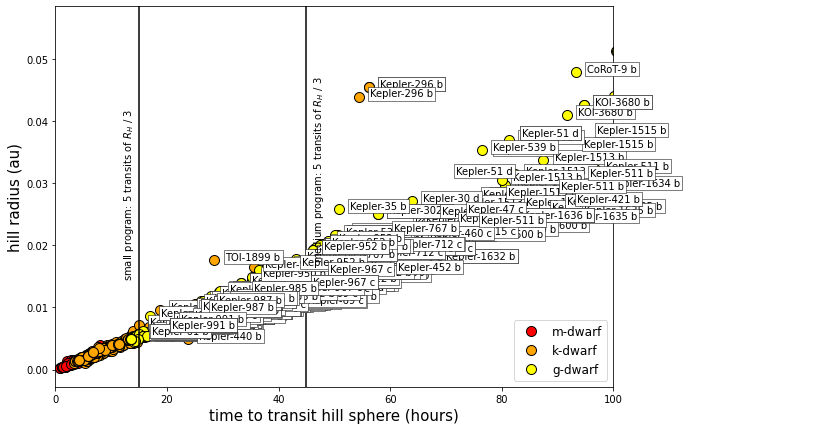

In [287]:
c = ((th / 3 * 5) < 100) & (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(10, 7))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(2*th[c][mdwarf], rh[c][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[c][kdwarf], rh[c][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[c][gdwarf], rh[c][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
pl.xlim(0, 100)
#pl.ylim(0, 0.06)

for t, r, pname in zip(th[c], rh[c], hz_planets[c]['pl_name']):
    if 2*t > 15:
        if pname == 'Kepler-442 b':
            pl.annotate(pname, xy=(2*t+2, r+0.001), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))
        elif pname == 'Kepler-47 c':
            pl.annotate(pname, xy=(2*t+2, r-0.001), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))
        else:
            pl.annotate(pname, xy=(2*t+2, r), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

pl.axvline(25 * 3 / 5, color='k')
pl.axvline(75 * 3 / 5, color='k')
pl.annotate(r'small program: 5 transits of $R_H\ /\ 3$', 
            xy=(25 * 3 / 5 - 3, 0.015), rotation=90, fontsize=10)
pl.annotate(r'medium program: 5 transits of $R_H\ /\ 3$', 
            xy=(75 * 3 / 5 + 1, 0.018), rotation=90, fontsize=10)

pl.xlabel('time to transit hill sphere (hours)', fontsize=15)
pl.ylabel('hill radius (au)', fontsize=15)
pl.legend(fontsize=12, loc='lower right')
pl.savefig('/Users/tgordon/Desktop/candidates.pdf')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/matplotlib/text.py:1771: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.7/site-packages/matplotlib/text.py:1771: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.7/site-packages/matplotlib/text.py:829: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(self._y))


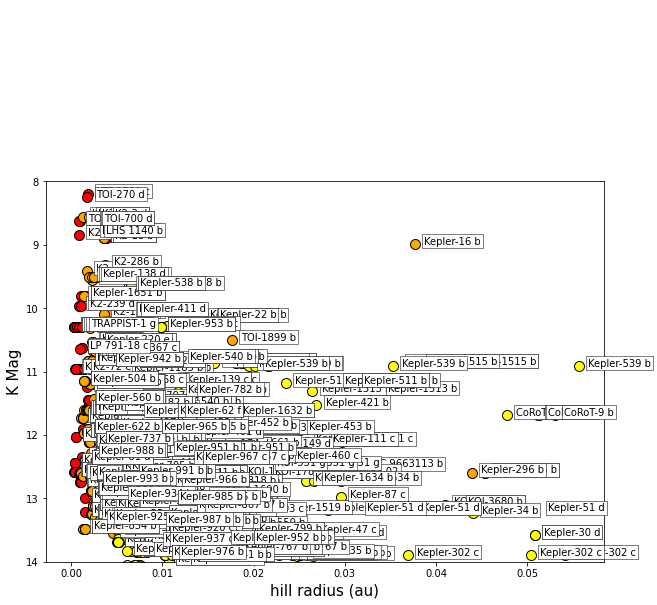

In [288]:
c = ((th / 3 * 5) < 100) & (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(10, 7))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(rh[c][mdwarf], hz_planets[c]['sy_kmag'][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(rh[c][kdwarf], hz_planets[c]['sy_kmag'][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(rh[c][gdwarf], hz_planets[c]['sy_kmag'][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
#pl.xlim(0, 100)
pl.ylim(14, 8)

for r, kmag, hname in zip(rh[c], hz_planets[c]['sy_kmag'], hz_planets[c]['pl_name']):
        pl.annotate(hname, xy=(r+0.001, kmag), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

#pl.axvline(25 * 3 / 5, color='k')
#pl.axvline(75 * 3 / 5, color='k')
#pl.annotate(r'small program: 5 transits of $R_H\ /\ 3$', 
#            xy=(25 * 3 / 5 - 3, 0.015), rotation=90, fontsize=10)
#pl.annotate(r'medium program: 5 transits of $R_H\ /\ 3$', 
#            xy=(75 * 3 / 5 + 1, 0.018), rotation=90, fontsize=10)

pl.xlabel('hill radius (au)', fontsize=15)
pl.ylabel('K Mag', fontsize=15)
#pl.legend(fontsize=12, loc='lower right')
pl.savefig('/Users/tgordon/Desktop/candidates_kmag.pdf')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/matplotlib/text.py:1771: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.7/site-packages/matplotlib/text.py:1771: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.7/site-packages/matplotlib/text.py:829: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(self._y))


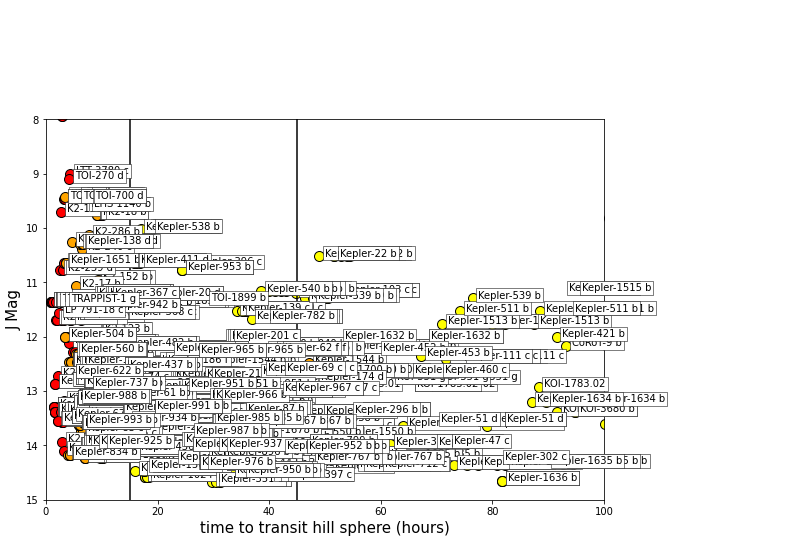

In [289]:
c = ((th / 3 * 5) < 100) & (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(10, 7))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(2*th[c][mdwarf], hz_planets[c]['sy_jmag'][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[c][kdwarf], hz_planets[c]['sy_jmag'][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[c][gdwarf], hz_planets[c]['sy_jmag'][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
pl.xlim(0, 100)
pl.ylim(15, 8)

for t, jmag, hname in zip(2*th[c], hz_planets[c]['sy_jmag'], hz_planets[c]['pl_name']):
        pl.annotate(hname, xy=(t+1, jmag), rotation=0, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

pl.axvline(25 * 3 / 5, color='k')
pl.axvline(75 * 3 / 5, color='k')
#pl.annotate(r'small program: 5 transits of $R_H\ /\ 3$', 
#            xy=(25 * 3 / 5 - 3, 0.015), rotation=90, fontsize=10)
#pl.annotate(r'medium program: 5 transits of $R_H\ /\ 3$', 
#            xy=(75 * 3 / 5 + 1, 0.018), rotation=90, fontsize=10)

pl.xlabel('time to transit hill sphere (hours)', fontsize=15)
pl.ylabel('J Mag', fontsize=15)
#pl.legend(fontsize=12, loc='lower right')
pl.savefig('/Users/tgordon/Desktop/candidates_kmag.pdf')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


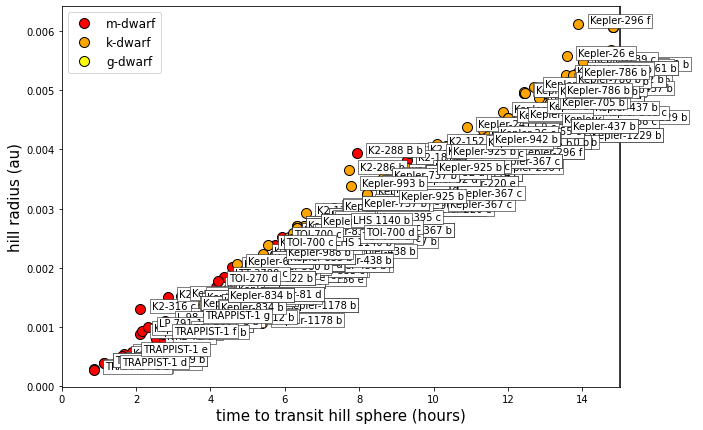

In [290]:
c = (th < 7.5) & (hz_planets['tran_flag'] == 1)
pl.figure(figsize=(10, 7))
mdwarf = hz_planets[c]['st_teff'] < 3500
kdwarf = (hz_planets[c]['st_teff'] > 3500) & (hz_planets[c]['st_teff'] < 5000)
gdwarf = (hz_planets[c]['st_teff'] > 5000) & (hz_planets[c]['st_teff'] < 6000)
pl.plot(2*th[c][mdwarf], rh[c][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(2*th[c][kdwarf], rh[c][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(2*th[c][gdwarf], rh[c][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
pl.xlim(0, 15)
#pl.ylim(0.01, 0.03)

for t, r, pname in zip(th[c], rh[c], hz_planets[c]['pl_name']):
    pl.annotate(pname, xy=(2*t+0.3, r), rotation=0, 
                bbox=dict(fc="white", lw=0.5, pad=2))

pl.axvline(25 * 3 / 5, color='k')
pl.axvline(75 * 3 / 5, color='k')

pl.xlabel('time to transit hill sphere (hours)', fontsize=15)
pl.ylabel('hill radius (au)', fontsize=15)
pl.legend(fontsize=12)
pl.savefig('/Users/tgordon/Desktop/candidates_zoom.pdf')

In [291]:
from astropy.io import ascii
from astropy.table import unique
targets = hz_planets[(2*hz_planets['pl_hilltime'] / 3 < (75 / 5)) & (hz_planets['tran_flag'] == 1)]
targets = unique(targets, keys='pl_name')
targets.sort('pl_hillrad')
targets.reverse()
fmtdict = {'pl_hillrad': '%0.3f', 'pl_minmass_med': '%0.3f', 'sy_jmag': '%0.3f'}
ascii.write(targets[(targets['sy_jmag'] < 13)]['pl_name', 'sy_jmag', 'pl_hillrad', 'st_teff', 'pl_minmass_med', 'pl_rade', 'cb_flag'], comment=False, delimiter='\t', formats=fmtdict)

/usr/local/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


pl_name	sy_jmag	pl_hillrad	st_teff	pl_minmass_med	pl_rade	cb_flag
KOI-1783.01	12.917	0.018	6215.0	0.130	7.5	0
TOI-1899 b	11.342	0.018	3841.0	2.689	15.356	0
Kepler-951 b	12.920	0.017	4850.0	0.370	6.21	0
Kepler-1661 b	12.729	0.016	5100.0	0.046	3.87	1
Kepler-103 c	11.193	0.016	5975.0	0.050	4.46	0
Kepler-149 d	12.694	0.015	5529.0	0.050	3.54	0
Kepler-1040 b	12.181	0.014	5793.0	0.027	3.05	0
Kepler-782 b	11.669	0.013	6126.0	0.041	3.73	0
Kepler-401 d	12.277	0.013	6115.0	0.027	2.57	0
Kepler-540 b	11.167	0.013	5839.0	0.030	3.13	0
Kepler-630 b	12.686	0.013	5761.0	0.033	3.25	0
Kepler-967 c	12.991	0.013	5080.0	0.022	2.86	0
Kepler-69 c	12.631	0.012	5637.0	0.012	1.74	0
Kepler-62 f	12.256	0.012	4797.0	0.009	1.42	0
Kepler-139 c	11.530	0.012	5616.0	0.027	2.81	0
Kepler-452 b	12.263	0.011	5579.0	0.004	1.09	0
Kepler-201 c	12.037	0.011	6131.0	0.022	2.31	0
Kepler-396 c	10.672	0.011	5593.0	0.062	4.7	0
Kepler-965 b	12.298	0.010	6010.0	0.027	2.59	0
Kepler-11 g	12.548	0.010	5657.0	0.033	3.46	0
Kepler-1540 b	12.2

In [292]:
from astropy.io import ascii
from astropy.table import unique
targets = hz_planets[(2*hz_planets['pl_hilltime'] / 3 < (75 / 5)) & (hz_planets['tran_flag'] == 1)]
targets = unique(targets, keys='pl_name')
targets.sort('sy_jmag')
fmtdict = {'pl_hillrad': '%0.3f', 'pl_minmass_med': '%0.3f', 'sy_jmag': '%0.3f'}
ascii.write(targets[(targets['sy_jmag'] < 13)]['pl_name', 'sy_jmag', 'pl_hillrad', 'st_teff', 'pl_minmass_med', 'pl_rade', 'cb_flag'], comment=False, delimiter='\t', formats=fmtdict)

/usr/local/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


pl_name	sy_jmag	pl_hillrad	st_teff	pl_minmass_med	pl_rade	cb_flag
GJ 143 b	6.081	0.004	4640.0	0.022	2.61	0
L 98-59 d	7.933	0.001	3412.0	0.009	1.57	0
LTT 3780 c	9.007	0.002	3331.0	0.018	2.3	0
TOI-270 d	9.099	0.002	3386.0	0.018	2.13	0
K2-3 d	9.421	0.002	3841.0	0.003	0.96	0
K2-3 b	9.421	0.001	3841.0	0.009	1.44	0
K2-3 c	9.421	0.002	3951.0	0.009	1.56	0
TOI-700 b	9.469	0.001	3461.0	0.003	1.037	0
TOI-700 c	9.469	0.003	3480.0	0.027	2.63	0
TOI-700 d	9.469	0.002	3461.0	0.005	1.144	0
LHS 1140 b	9.612	0.002	3131.0	0.009	1.43	0
K2-129 b	9.697	0.001	3459.09	0.004	1.04	0
K2-18 b	9.763	0.004	3457.0	0.022	2.279	0
Kepler-538 b	10.026	0.007	5564.0	0.018	2.13	0
K2-286 b	10.127	0.004	3926.0	0.018	2.1	0
K2-21 c	10.251	0.002	4006.0	0.009	1.53	0
K2-155 d	10.274	0.004	3919.0	0.012	1.64	0
Kepler-138 d	10.293	0.003	3900.0	0.018	2.06	0
K2-240 c	10.394	0.002	3810.0	0.014	1.8	0
Kepler-411 d	10.641	0.006	4987.0	0.033	3.51	0
Kepler-1651 b	10.648	0.001	3240.0	0.005	1.15	0
Kepler-396 c	10.672	0.011	5593.0	0.062	4.7	0
K

Text(0, 0.5, 'J Mag')

/usr/local/lib/python3.7/site-packages/matplotlib/text.py:1771: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.7/site-packages/matplotlib/text.py:829: UserWarning: Warning: converting a masked element to nan.
  y = float(self.convert_yunits(self._y))


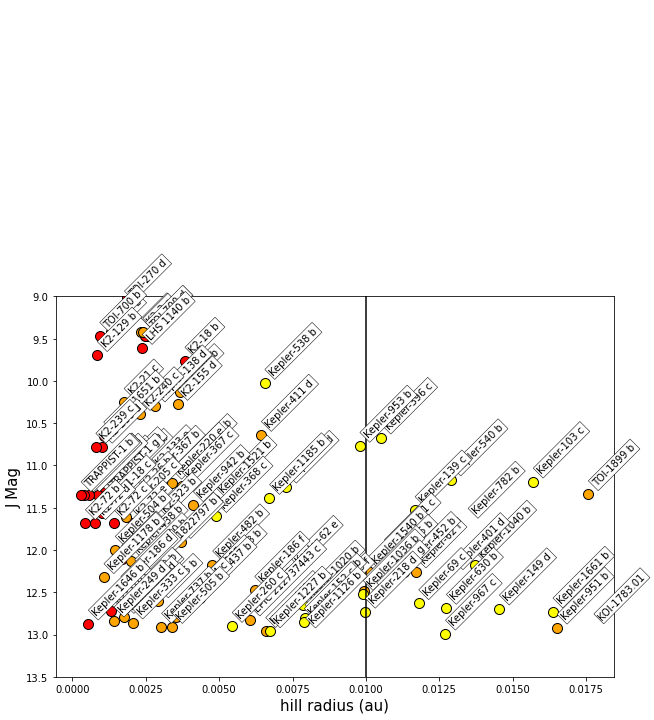

In [293]:
c = (targets['sy_jmag'] < 13)
pl.figure(figsize=(10, 7))
mdwarf = targets[c]['st_teff'] < 3500
kdwarf = (targets[c]['st_teff'] > 3500) & (targets[c]['st_teff'] < 5000)
gdwarf = (targets[c]['st_teff'] > 5000) & (targets[c]['st_teff'] < 6000)
pl.plot(targets[c]['pl_hillrad'][mdwarf], targets[c]['sy_jmag'][mdwarf], 'o', color='red', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='m-dwarf')
pl.plot(targets[c]['pl_hillrad'][kdwarf], targets[c]['sy_jmag'][kdwarf], 'o', color='orange', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='k-dwarf')
pl.plot(targets[c]['pl_hillrad'][gdwarf], targets[c]['sy_jmag'][gdwarf], 'o', color='yellow', 
        markeredgewidth=1, markeredgecolor='k', markersize=10, label='g-dwarf')
#pl.xlim(0, 100)
pl.ylim(13.5, 9)

for r, jmag, hname in zip(targets[c]['pl_hillrad'], targets[c]['sy_jmag'], targets[c]['pl_name']):
        pl.annotate(hname, xy=(r+0.0001, jmag-0.1), rotation=45, 
                    bbox=dict(fc="white", lw=0.5, pad=2))

#pl.axvline(25 * 3 / 5, color='k')
#pl.axvline(75 * 3 / 5, color='k')
pl.axvline(0.01, color='k')

pl.xlabel('hill radius (au)', fontsize=15)
pl.ylabel('J Mag', fontsize=15)
#pl.legend(fontsize=12, loc='lower right')
#pl.savefig('/Users/tgordon/Desktop/candidates_kmag.pdf')

In [294]:
hz_planets[hz_planets['pl_name'] == 'Kepler-296 f']['sy_jmag']

13.391
13.391
13.391
13.391
13.391
13.391
13.391
13.391
13.391
